In [1]:
# === Diffusion scratch implementation (DDPM) ===
# Import necessary libraries

import os
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# ---------- User config ----------
DATA_DIR = "/kaggle/input/bitmojis/bitmojis"  
IMG_SIZE = 64
BATCH_SIZE = 32
NUM_WORKERS = 4
LR = 2e-4
EPOCHS = 30            # increase for better results
T_STEPS = 200          # diffusion steps (200 typical for experiments)
SAVE_EVERY = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = "ddpm_out"
os.makedirs(OUT_DIR, exist_ok=True)
print("Device:", DEVICE)

Device: cuda


## Load Dataset

In [2]:
# DATASET
# -------------------------------
class ImageFolderDataset(Dataset):
    def __init__(self, folder, image_size=64, exts=("jpg","jpeg","png","bmp")):
        self.paths = []
        p = Path(folder)
        for ext in exts:
            self.paths += list(p.rglob(f"*.{ext}"))
        if len(self.paths) == 0:
            raise ValueError(f"No images found in {folder}")
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.transform(img)

dataset = ImageFolderDataset(DATA_DIR, IMG_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
print("Dataset size:", len(dataset))

Dataset size: 130227


In [3]:
# --------- Beta schedule & precomputations ----------
def linear_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

betas = linear_beta_schedule(T_STEPS).to(DEVICE)                     # (T,)
alphas = 1.0 - betas                                                 # (T,)
alphas_cumprod = torch.cumprod(alphas, dim=0)                        # (T,)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)   # (T,)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# posterior variance (used for sampling)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)  # shape (T,)

In [4]:
# ----------------- Sinusoidal time embedding -----------------
# produces vector of size dim (like transformer positional enc)
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):  # t shape (B,)
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half)
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)  # (B, half)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1), value=0.)
        return emb  # (B, dim)

In [5]:
# ----------------- Tiny U-Net (size-preserving architecture) -----------------
# This U-Net is intentionally small for speed but has skip connections and time conditioning.
class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_emb = nn.Sequential(SinusoidalPosEmb(time_emb_dim), nn.Linear(time_emb_dim, time_emb_dim), nn.SiLU(), nn.Linear(time_emb_dim, time_emb_dim))
        # Encoder
        self.enc1 = ResidualConvBlock(in_ch, base_ch)          # 64x64
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 3, stride=2, padding=1) # 32x32
        self.enc2 = ResidualConvBlock(base_ch*2, base_ch*2)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 3, stride=2, padding=1) # 16x16
        self.enc3 = ResidualConvBlock(base_ch*4, base_ch*4)
        # Bottleneck
        self.bot = ResidualConvBlock(base_ch*4, base_ch*4)
        # Decoder
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1) # 32x32
        self.dec2 = ResidualConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1) # 64x64
        self.dec1 = ResidualConvBlock(base_ch*2, base_ch)
        # Output
        self.out = nn.Sequential(nn.Conv2d(base_ch, in_ch, 1), nn.Tanh())

        # time -> channel bias projection
        self.time_proj = nn.Sequential(nn.Linear(time_emb_dim, base_ch*4), nn.SiLU())

    def forward(self, x, t):
        # x: (B,3,H,W), t: (B,) integer timesteps
        temb = self.time_emb(t)        # (B, time_emb_dim)
        tproj = self.time_proj(temb)   # (B, base_ch*4)
        # Encoder
        e1 = self.enc1(x)              # (B, base_ch, H, W)
        d1 = self.down1(e1)            # (B, base_ch*2, H/2, W/2)
        e2 = self.enc2(d1)             # (B, base_ch*2, H/2, W/2)
        d2 = self.down2(e2)            # (B, base_ch*4, H/4, W/4)
        e3 = self.enc3(d2)             # (B, base_ch*4, H/4, W/4)

        # Add time conditioning to bottleneck
        bot = self.bot(e3 + tproj.view(-1, tproj.size(-1), 1, 1))

        # Decoder with skips
        u2 = self.up2(bot)             # (B, base_ch*2, H/2, W/2)
        cat2 = torch.cat([u2, e2], dim=1)
        dec2 = self.dec2(cat2)

        u1 = self.up1(dec2)            # (B, base_ch, H, W)
        cat1 = torch.cat([u1, e1], dim=1)
        dec1 = self.dec1(cat1)

        out = self.out(dec1)           # (B, 3, H, W) values in [-1,1]
        return out

# Instantiate model
model = TinyUNet(in_ch=3, base_ch=64, time_emb_dim=128).to(DEVICE)
print("Model parameters:", sum(p.numel() for p in model.parameters())/1e6, "M")

Model parameters: 4.383363 M


In [6]:
# ---------- helper functions: q_sample (forward), predict x0 from noise, p_mean_variance (reverse) ----------
# q_sample: produce x_t from x0 and noise
def q_sample(x0, t, noise=None):
    """
    x0: (B,3,H,W) values in normalized [-1,1] (we store images in that range)
    t: (B,) integer timesteps [0..T-1]
    returns: x_t, noise
    """
    if noise is None:
        noise = torch.randn_like(x0).to(x0.device)
    # gather constants for each sample
    a_cum = alphas_cumprod[t].view(-1,1,1,1).to(x0.device)
    sq_a = torch.sqrt(a_cum)
    sq_om = torch.sqrt(1.0 - a_cum)
    x_t = sq_a * x0 + sq_om * noise
    return x_t, noise

In [7]:
# Given predicted noise epsilon_theta(x_t, t), compute mean and variance for p(x_{t-1} | x_t)
def p_mean_variance(model, x_t, t):
    """
    returns model_mean, posterior_variance_t (both tensors)
    model predicts noise epsilon
    """
    # Predict noise
    eps_theta = model(x_t, t)
    # get scalars
    a_t = alphas[t].view(-1,1,1,1).to(x_t.device)
    a_bar_t = alphas_cumprod[t].view(-1,1,1,1).to(x_t.device)
    a_bar_prev = alphas_cumprod_prev[t].view(-1,1,1,1).to(x_t.device)
    beta_t = betas[t].view(-1,1,1,1).to(x_t.device)

    # x0_pred from eq: x0 = (x_t - sqrt(1-a_bar_t) * eps) / sqrt(a_bar_t)
    x0_pred = (x_t - torch.sqrt(1. - a_bar_t) * eps_theta) / torch.sqrt(a_bar_t)
    # clip x0_pred to [-1,1] (paper suggests clipping)
    x0_pred = torch.clamp(x0_pred, -1., 1.)

    # compute posterior mean μ_t = ( sqrt(a_bar_prev) * beta_t * x0 + (1 - a_bar_prev) * sqrt(a_t) * eps ) / (1 - a_bar_t)
    coef1 = beta_t * torch.sqrt(a_bar_prev) / (1. - a_bar_t)
    coef2 = (1. - a_bar_prev) * torch.sqrt(a_t) / (1. - a_bar_t)
    model_mean = coef1 * x0_pred + coef2 * eps_theta

    # variance for sampling
    var = posterior_variance[t].view(-1,1,1,1).to(x_t.device)
    return model_mean, var, x0_pred

In [8]:
# p_sample: sample x_{t-1} from x_t
@torch.no_grad()
def p_sample_once(model, x_t, t):
    model_mean, var, x0_pred = p_mean_variance(model, x_t, t)
    if t[0] == 0:
        return model_mean  # deterministic at t=0
    noise = torch.randn_like(x_t).to(x_t.device)
    return model_mean + torch.sqrt(var) * noise

In [9]:
# full sampling chain (generate from pure noise)
@torch.no_grad()
def sample_loop(model, shape=(1,3,IMG_SIZE,IMG_SIZE), device=DEVICE, return_intermediate=False):
    model.eval()
    B = shape[0]
    x = torch.randn(shape, device=device)
    intermediates = []
    for step in reversed(range(T_STEPS)):
        t = torch.full((B,), step, dtype=torch.long, device=device)
        x = p_sample_once(model, x, t)
        if return_intermediate and (step % (T_STEPS//7) == 0 or step in [0,1]):
            intermediates.append(x.detach().cpu())
    if return_intermediate:
        return x.detach().cpu(), intermediates
    return x.detach().cpu()

In [10]:
# ----------- Training setup ----------
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

# training loop
global_step = 0
for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}")
    running_loss = 0.0
    for batch in pbar:
        x0 = batch.to(DEVICE)   # expected in [-1,1]
        B = x0.size(0)
        t = torch.randint(0, T_STEPS, (B,), device=DEVICE).long()  # random timesteps per sample
        x_t, noise = q_sample(x0, t)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            eps_pred = model(x_t, t)
            loss = F.mse_loss(eps_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        global_step += 1
        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{running_loss/global_step:.6f}"})

    avg_epoch_loss = running_loss / (len(loader) if len(loader)>0 else 1)
    print(f"Epoch {epoch} avg loss: {avg_epoch_loss:.6f}")

    # checkpoint & sample
    if epoch % SAVE_EVERY == 0:
        torch.save(model.state_dict(), os.path.join(OUT_DIR, f"model_epoch{epoch}.pt"))
        # sample few images and save
        sample_batch, intermediates = sample_loop(model, shape=(4,3,IMG_SIZE,IMG_SIZE), return_intermediate=True)
        # denormalize and save grid
        grid = make_grid((sample_batch+1)/2, nrow=4)
        save_image(grid, os.path.join(OUT_DIR, f"sample_epoch{epoch}.png"))

        # save intermediate progression (denoise)
        for i, img_t in enumerate(intermediates):
            g = make_grid((img_t+1)/2, nrow=4)
            save_image(g, os.path.join(OUT_DIR, f"sample_epoch{epoch}_step{i}.png"))

Epoch 1/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 1 avg loss: 0.185328


Epoch 2/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 2 avg loss: 0.167008


Epoch 3/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 3 avg loss: 0.163670


Epoch 4/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 4 avg loss: 0.162366


Epoch 5/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 5 avg loss: 0.161311


Epoch 6/30:   0%|          | 0/4070 [01:00<?, ?it/s]

Epoch 6 avg loss: 0.160821


Epoch 7/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 7 avg loss: 0.160403


Epoch 8/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 8 avg loss: 0.160032


Epoch 9/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 9 avg loss: 0.159589


Epoch 10/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 10 avg loss: 0.159500


Epoch 11/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 11 avg loss: 0.159282


Epoch 12/30:   0%|          | 0/4070 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 12 avg loss: 0.158945


Epoch 13/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 13 avg loss: 0.158817


Epoch 14/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 14 avg loss: 0.158669


Epoch 15/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 15 avg loss: 0.158578


Epoch 16/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 16 avg loss: 0.158402


Epoch 17/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 17 avg loss: 0.158370


Epoch 18/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0a9c23cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0a9c23cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch 18 avg loss: 0.158175


Epoch 19/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 19 avg loss: 0.158133


Epoch 20/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 20 avg loss: 0.158052


Epoch 21/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 21 avg loss: 0.157982


Epoch 22/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 22 avg loss: 0.157851


Epoch 23/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 23 avg loss: 0.157797


Epoch 24/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0a9c23cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0a9c23cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch 24 avg loss: 0.157734


Epoch 25/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 25 avg loss: 0.157674


Epoch 26/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 26 avg loss: 0.157703


Epoch 27/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 27 avg loss: 0.157589


Epoch 28/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 28 avg loss: 0.157528


Epoch 29/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 29 avg loss: 0.157479


Epoch 30/30:   0%|          | 0/4070 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0a9c23cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0a9c23cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

  File "/o

Epoch 30 avg loss: 0.157403


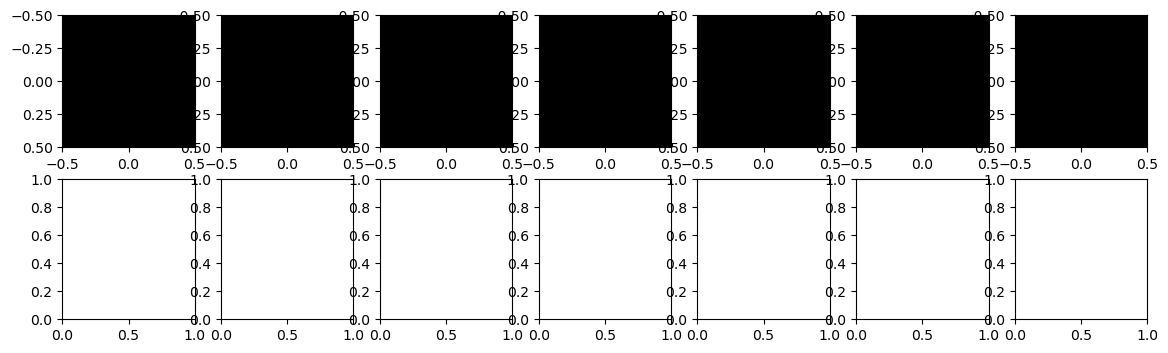

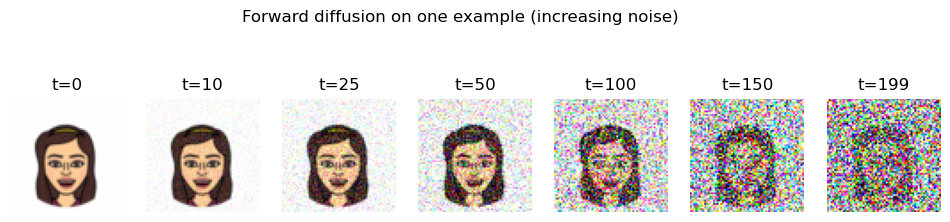

In [11]:
# ---------------- Visualization of forward noise on a batch --------------
def visualize_forward_on_batch(model, data_loader, num_images=4):
    model.eval()
    batch = next(iter(data_loader)).to(DEVICE)
    x0 = batch[:num_images]
    fig, axes = plt.subplots(2, 7, figsize=(14,4))
    t_values = [0, 10, 25, 50, 100, 150, T_STEPS-1]
    for i, t in enumerate(t_values):
        tvec = torch.full((num_images,), t, device=DEVICE, dtype=torch.long)
        x_t, _ = q_sample(x0, tvec)
        x_t_np = ((x_t.cpu()+1)/2).permute(0,2,3,1).numpy()
        for j in range(num_images):
            axes[0, i].imshow(np.zeros((1,1,3)))  # placeholder for layout
    # We'll just show for one image across time
    plt.figure(figsize=(12,3))
    for i, t in enumerate(t_values):
        x_t, _ = q_sample(x0[0:1], torch.tensor([t], device=DEVICE))
        im = ((x_t[0].cpu()+1)/2).permute(1,2,0).numpy()
        plt.subplot(1,7,i+1); plt.imshow(im); plt.axis('off'); plt.title(f"t={t}")
    plt.suptitle("Forward diffusion on one example (increasing noise)")
    plt.show()

visualize_forward_on_batch(model, loader, num_images=4)

In [12]:
# -------------- Evaluation: Noise prediction mse & reconstruction MSE ---------------
@torch.no_grad()
def eval_noise_mse(model, data_loader, num_batches=10):
    model.eval()
    total = 0.0; count=0
    for i, batch in enumerate(data_loader):
        if i>=num_batches: break
        x0 = batch.to(DEVICE)
        B = x0.size(0)
        t = torch.randint(0, T_STEPS, (B,), device=DEVICE)
        x_t, noise = q_sample(x0, t)
        eps_pred = model(x_t, t)
        total += F.mse_loss(eps_pred, noise, reduction="sum").item()
        count += x0.numel()
    return total / count

mse_noise = eval_noise_mse(model, loader, num_batches=20)
print("Noise prediction MSE (eval):", mse_noise)

Noise prediction MSE (eval): 0.15696080774068832


In [13]:
# Reconstruction MSE example: take one image, fully denoise then compare to original
@torch.no_grad()
def reconstruct_and_mse(model, data_loader):
    model.eval()
    batch = next(iter(data_loader)).to(DEVICE)
    x0 = batch[0:1]  # single example
    # forward to t_max
    tmax = T_STEPS-1
    x_t, noise = q_sample(x0, torch.tensor([tmax], device=DEVICE))
    # now reverse
    x = x_t
    for step in reversed(range(T_STEPS)):
        tvec = torch.full((1,), step, device=DEVICE, dtype=torch.long)
        x = p_sample_once(model, x, tvec)
    # compute mse between reconstructed x (x) and original x0
    mse = F.mse_loss(x, x0).item()
    return mse, x0.cpu(), x.cpu()

recon_mse, orig, recon = reconstruct_and_mse(model, loader)
print("Reconstruction MSE (one example):", recon_mse)

Reconstruction MSE (one example): 1.7891814708709717


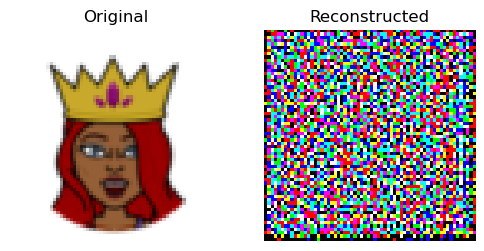

All outputs (samples + intermediates + checkpoints) are saved in: ddpm_out


In [14]:
# Visualize orig vs recon
orig_im = ((orig[0]+1)/2).permute(1,2,0).numpy()
recon_im = ((recon[0]+1)/2).permute(1,2,0).numpy()
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(orig_im); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(recon_im); plt.title("Reconstructed"); plt.axis('off')
plt.show()

print("All outputs (samples + intermediates + checkpoints) are saved in:", OUT_DIR)